# Imports

In [64]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import os
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Preparing data

In [89]:
train_path = './myArchive/train'
test_path = './AI'
valid_path = './myArchive/valid'

img_size = 256
batch_size = 16

# Define ImageDataGenerators for loading and augmenting the data
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest' )
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators for each set
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

class_names = list(train_generator.class_indices.keys())
class_names_len = len(class_names)

class Metrics(keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(Metrics, self).__init__()
        self.validation_data = validation_data

    def on_train_begin(self, logs=None):
        self.val_f1s = []
        self.train_f1s = []

    def on_epoch_end(self, epoch, logs=None):
        val_data = self.validation_data
        train_predict = np.argmax(self.model.predict(self.validation_data[0]), axis=1)
        train_targ = np.argmax(self.validation_data[1], axis=1)
        train_f1 = f1_score(train_targ, train_predict, average='macro')
        self.train_f1s.append(train_f1)

        val_predict = np.argmax(self.model.predict(val_data[0]), axis=1)
        val_targ = np.argmax(val_data[1], axis=1)
        val_f1 = f1_score(val_targ, val_predict, average='macro')
        self.val_f1s.append(val_f1)

        print(f'Epoch {epoch+1} — Train F1: {train_f1:.4f} — Val F1: {val_f1:.4f}')
        return

validation_data = (valid_generator[0][0], valid_generator[0][1])

# Display class names
print("Class names:", class_names)

Found 1946 images belonging to 10 classes.
Found 493 images belonging to 10 classes.
Found 400 images belonging to 10 classes.
Class names: ['AFRICAN LEOPARD', 'CARACAL', 'CHEETAH', 'CLOUDED LEOPARD', 'JAGUAR', 'LIONS', 'OCELOT', 'PUMA', 'SNOW LEOPARD', 'TIGER']


# Training

### My model

In [47]:
# Build the model
my_model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(class_names_len, activation='softmax'),
])

# Compile the model
my_model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_path = "training_1/cp.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
metrics_my = Metrics(validation_data)

### EfficientNetB0

In [48]:
# Load EfficientNetB0 model with pre-trained weights
base_effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model
base_effnet.trainable = False

# Add custom layers on top of the base model
x = GlobalAveragePooling2D()(base_effnet.output)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
output_effnet = Dense(class_names_len, activation='softmax')(x)

model_effnet = Model(inputs=base_effnet.input, outputs=output_effnet)

# Compile the model
model_effnet.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
metrics_effnet = Metrics(validation_data)

### ResNet50

In [49]:
# Load the pre-trained ResNet50 model without the top classification layer
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

base_resnet.trainable = False

# Add custom layers on top of the base model
x = GlobalAveragePooling2D()(base_resnet.output)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
output_resnet = Dense(class_names_len, activation='softmax')(x)

# Create the final model
model_resnet = Model(inputs=base_resnet.input, outputs=output_resnet)

# Compile the model
model_resnet.compile(optimizer='Adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
metrics_resnet = Metrics(validation_data)

## Train models

In [79]:
epohs = 40

# Train the model
my_history = my_model.fit(
    train_generator,
    epochs=epohs,
    validation_data=valid_generator,
    callbacks=[cp_callback, metrics_my])

# Train the model
history_effnet = model_effnet.fit(
    train_generator,
    epochs=epohs,
    validation_data=valid_generator,
    callbacks=[metrics_effnet])


# Train the model
history_resnet = model_resnet.fit(
    train_generator,
    epochs=epohs,
    validation_data=valid_generator,
    callbacks=[metrics_resnet])

histories = [('My model', my_history), ('Effnet', history_effnet), ('Resnet', history_resnet)]

histories = [
    ('My model', my_history, metrics_my.train_f1s, metrics_my.val_f1s),
    ('Effnet', history_effnet, metrics_effnet.train_f1s, metrics_effnet.val_f1s),
    ('Resnet', history_resnet, metrics_resnet.train_f1s, metrics_resnet.val_f1s)
]

Epoch 1/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.4637 - loss: 1.3495
Epoch 1: saving model to training_1/cp.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Epoch 1 — Train F1: 0.3956 — Val F1: 0.3956
122/122 ━━━━━━━━━━━━━━━━━━━━ 33s 261ms/step - accuracy: 0.4637 - loss: 1.3495 - val_accuracy: 0.5294 - val_loss: 1.2475
Epoch 2/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.4679 - loss: 1.3333
Epoch 2: saving model to training_1/cp.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Epoch 2 — Train F1: 0.3657 — Val F1: 0.3657
122/122 ━━━━━━━━━━━━━━━━━━━━ 32s 255ms/step - accuracy: 0.4682 - loss: 1.3329 - val_accuracy: 0.5172 - val_loss: 1.2962
Epoch 3/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.5324 - loss: 1.2149
Epoch 3: saving model to training_1/cp.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Epoch 3 — Train F1: 0.6074 — V

# Testing the model

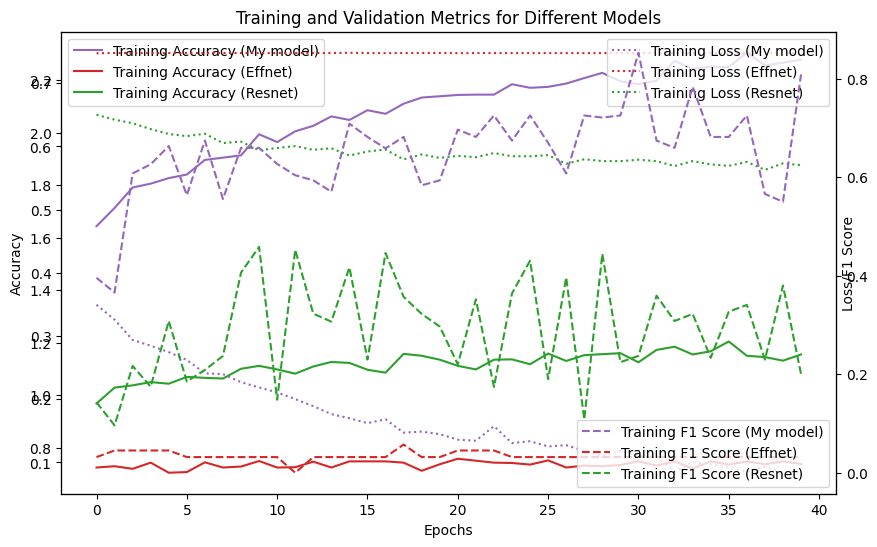

In [96]:
metrics_to_plot = ['accuracy', 'loss']

fig, ax1 = plt.subplots(figsize=(10, 6))
colors = ['tab:purple', 'tab:red', 'tab:green']

# Plot accuracy
for idx, (label, history, train_f1s, val_f1s) in enumerate(histories):
    color = colors[idx]
    ax1.plot(history.history['accuracy'], label=f'Training Accuracy ({label})', color=color)

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')

# Create a second y-axis to plot training and validation loss
ax2 = ax1.twinx()

# Plot loss
for idx, (label, history, train_f1s, val_f1s) in enumerate(histories):
    color = colors[idx]
    ax2.plot(history.history['loss'], label=f'Training Loss ({label})', color=color, linestyle='dotted')

ax2.set_ylabel('Loss/F1 Score')
ax2.tick_params(axis='y')
ax2.legend(loc='upper right')

ax3 = ax2.twinx()

for idx, (label, history, train_f1s, val_f1s) in enumerate(histories):
    color = colors[idx]
    ax3.plot(train_f1s, label=f'Training F1 Score ({label})', color=color, linestyle='dashed')

ax3.set_xlabel('Epochs')
ax3.tick_params(axis='y')
ax3.legend(loc='lower right')

# Title for the entire plot
plt.title('Training and Validation Metrics for Different Models')
plt.show()

fig.savefig("./results/resultsGraph1.png")
plt.close()


In [82]:
# Evaluate the model on the test dataset
test_loss_my, test_acc_my = my_model.evaluate(test_generator)
test_loss_effnet, test_acc_effnet = model_effnet.evaluate(test_generator)
test_loss_resnet, test_acc_resnet = model_resnet.evaluate(test_generator)

# Generate predictions
predicted_labels_my = np.argmax(my_model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1), axis=1)
predicted_labels_effnet = np.argmax(model_effnet.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1), axis=1)
predicted_labels_resnet = np.argmax(model_resnet.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1), axis=1)


# Gather true labels
true_labels = []
for i in range(len(test_generator)):
    _, labels = test_generator[i]
    true_labels.extend(np.argmax(labels, axis=1))
true_labels = np.array(true_labels)

# Gather true labels
# true_labels = test_generator.classes

f1_score_my = f1_score(true_labels, predicted_labels_my[:len(true_labels)], average='weighted')
f1_score_effnet = f1_score(true_labels, predicted_labels_effnet[:len(true_labels)], average='weighted')
f1_score_resnet = f1_score(true_labels, predicted_labels_resnet[:len(true_labels)], average='weighted')

# Classification report
print('My Classification Report:\n', classification_report(true_labels, predicted_labels_my[:len(true_labels)], target_names=class_names))

25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 323ms/step - accuracy: 0.2931 - loss: 3.0031
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 277ms/step - accuracy: 0.1335 - loss: 2.3020
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 335ms/step - accuracy: 0.1236 - loss: 2.7604
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 265ms/step


c:\Users\Poka\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 266ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 325ms/step
My Classification Report:
                  precision    recall  f1-score   support

AFRICAN LEOPARD       0.11      0.05      0.07        40
        CARACAL       0.11      0.07      0.09        40
        CHEETAH       0.14      0.07      0.10        40
CLOUDED LEOPARD       0.25      0.05      0.08        40
         JAGUAR       0.14      0.17      0.15        40
          LIONS       0.04      0.03      0.03        40
         OCELOT       0.00      0.00      0.00        40
           PUMA       0.09      0.38      0.14        40
   SNOW LEOPARD       0.07      0.05      0.06        40
          TIGER       0.14      0.10      0.12        40

       accuracy                           0.10       400
      macro avg       0.11      0.10      0.08       400
   weighted avg       0.11      0.10      0.08       400



In [83]:
print('ResNet Classification Report:\n', classification_report(true_labels, predicted_labels_resnet[:len(true_labels)], target_names=class_names))

ResNet Classification Report:
                  precision    recall  f1-score   support

AFRICAN LEOPARD       0.10      0.07      0.09        40
        CARACAL       0.08      0.07      0.08        40
        CHEETAH       0.06      0.07      0.07        40
CLOUDED LEOPARD       0.00      0.00      0.00        40
         JAGUAR       0.08      0.12      0.10        40
          LIONS       0.15      0.05      0.08        40
         OCELOT       0.09      0.05      0.06        40
           PUMA       0.00      0.00      0.00        40
   SNOW LEOPARD       0.00      0.00      0.00        40
          TIGER       0.09      0.42      0.15        40

       accuracy                           0.09       400
      macro avg       0.07      0.09      0.06       400
   weighted avg       0.07      0.09      0.06       400



In [84]:
print('EffNet Classification Report:\n', classification_report(true_labels, predicted_labels_effnet[:len(true_labels)], target_names=class_names))

EffNet Classification Report:
                  precision    recall  f1-score   support

AFRICAN LEOPARD       0.00      0.00      0.00        40
        CARACAL       0.00      0.00      0.00        40
        CHEETAH       0.00      0.00      0.00        40
CLOUDED LEOPARD       0.00      0.00      0.00        40
         JAGUAR       0.10      1.00      0.18        40
          LIONS       0.00      0.00      0.00        40
         OCELOT       0.00      0.00      0.00        40
           PUMA       0.00      0.00      0.00        40
   SNOW LEOPARD       0.00      0.00      0.00        40
          TIGER       0.00      0.00      0.00        40

       accuracy                           0.10       400
      macro avg       0.01      0.10      0.02       400
   weighted avg       0.01      0.10      0.02       400



c:\Users\Poka\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Poka\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Poka\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

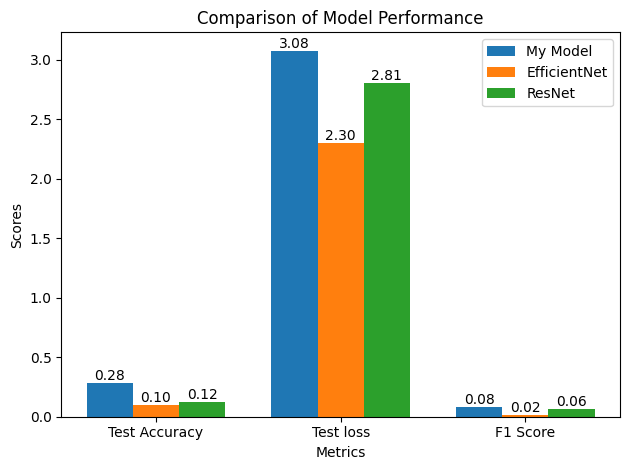

In [97]:
labels = ['Test Accuracy', 'Test loss', 'F1 Score']
my_model_graph_data = [test_acc_my, test_loss_my, f1_score_my]
effnet_model_graph_data = [test_acc_effnet, test_loss_effnet, f1_score_effnet]
resnet_model_graph_data = [test_acc_resnet, test_loss_resnet, f1_score_resnet]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, my_model_graph_data, width, label='My Model')
rects2 = ax.bar(x, effnet_model_graph_data, width, label='EfficientNet')
rects3 = ax.bar(x + width, resnet_model_graph_data, width, label='ResNet')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2., 
            height, 
            f'{height:.2f}', 
            ha='center', 
            va='bottom'
        )

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

fig.tight_layout()

plt.show()

fig.savefig("./results/resultsBarChart.png")
plt.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


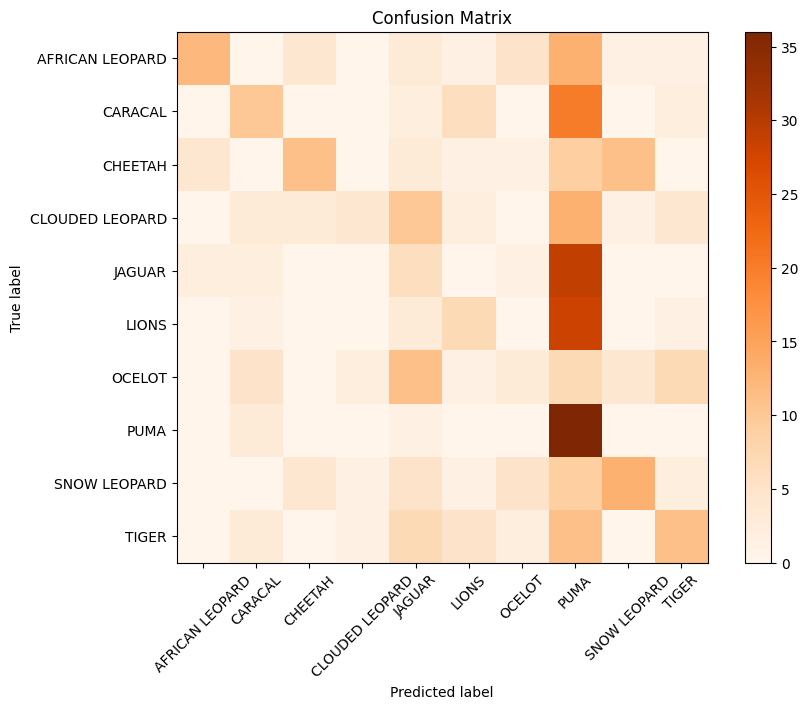

In [98]:
true_labels = []
predicted_labels = []

for i in range(len(test_generator)):
    x_batch, y_batch = test_generator[i]
    predictions = my_model.predict(x_batch)
    true_labels.extend(np.argmax(y_batch, axis=1))  # Convert one-hot encoded labels to class indices
    predicted_labels.extend(np.argmax(predictions, axis=1))

# Calculate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(9, 7))
# Create a visualization of the confusion matrix
classes = [str(i) for i in range(len(test_generator.class_indices))]
plt.imshow(confusion, interpolation='nearest', cmap=plt.get_cmap('Oranges'))
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(class_names_len)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

fig.savefig("./results/confusionMatrix.png")
plt.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
16
['OCELOT', 'PUMA', 'JAGUAR', 'AFRICAN LEOPARD', 'TIGER', 'CHEETAH', 'AFRICAN LEOPARD', 'PUMA', 'AFRICAN LEOPARD', 'SNOW LEOPARD', 'CHEETAH', 'CARACAL', 'SNOW LEOPARD', 'SNOW LEOPARD', 'CHEETAH', 'PUMA']
['LIONS', 'LIONS', 'LIONS', 'TIGER', 'CLOUDED LEOPARD', 'SNOW LEOPARD', 'CHEETAH', 'CLOUDED LEOPARD', 'SNOW LEOPARD', 'SNOW LEOPARD', 'CHEETAH', 'CLOUDED LEOPARD', 'CLOUDED LEOPARD', 'SNOW LEOPARD', 'TIGER', 'TIGER']


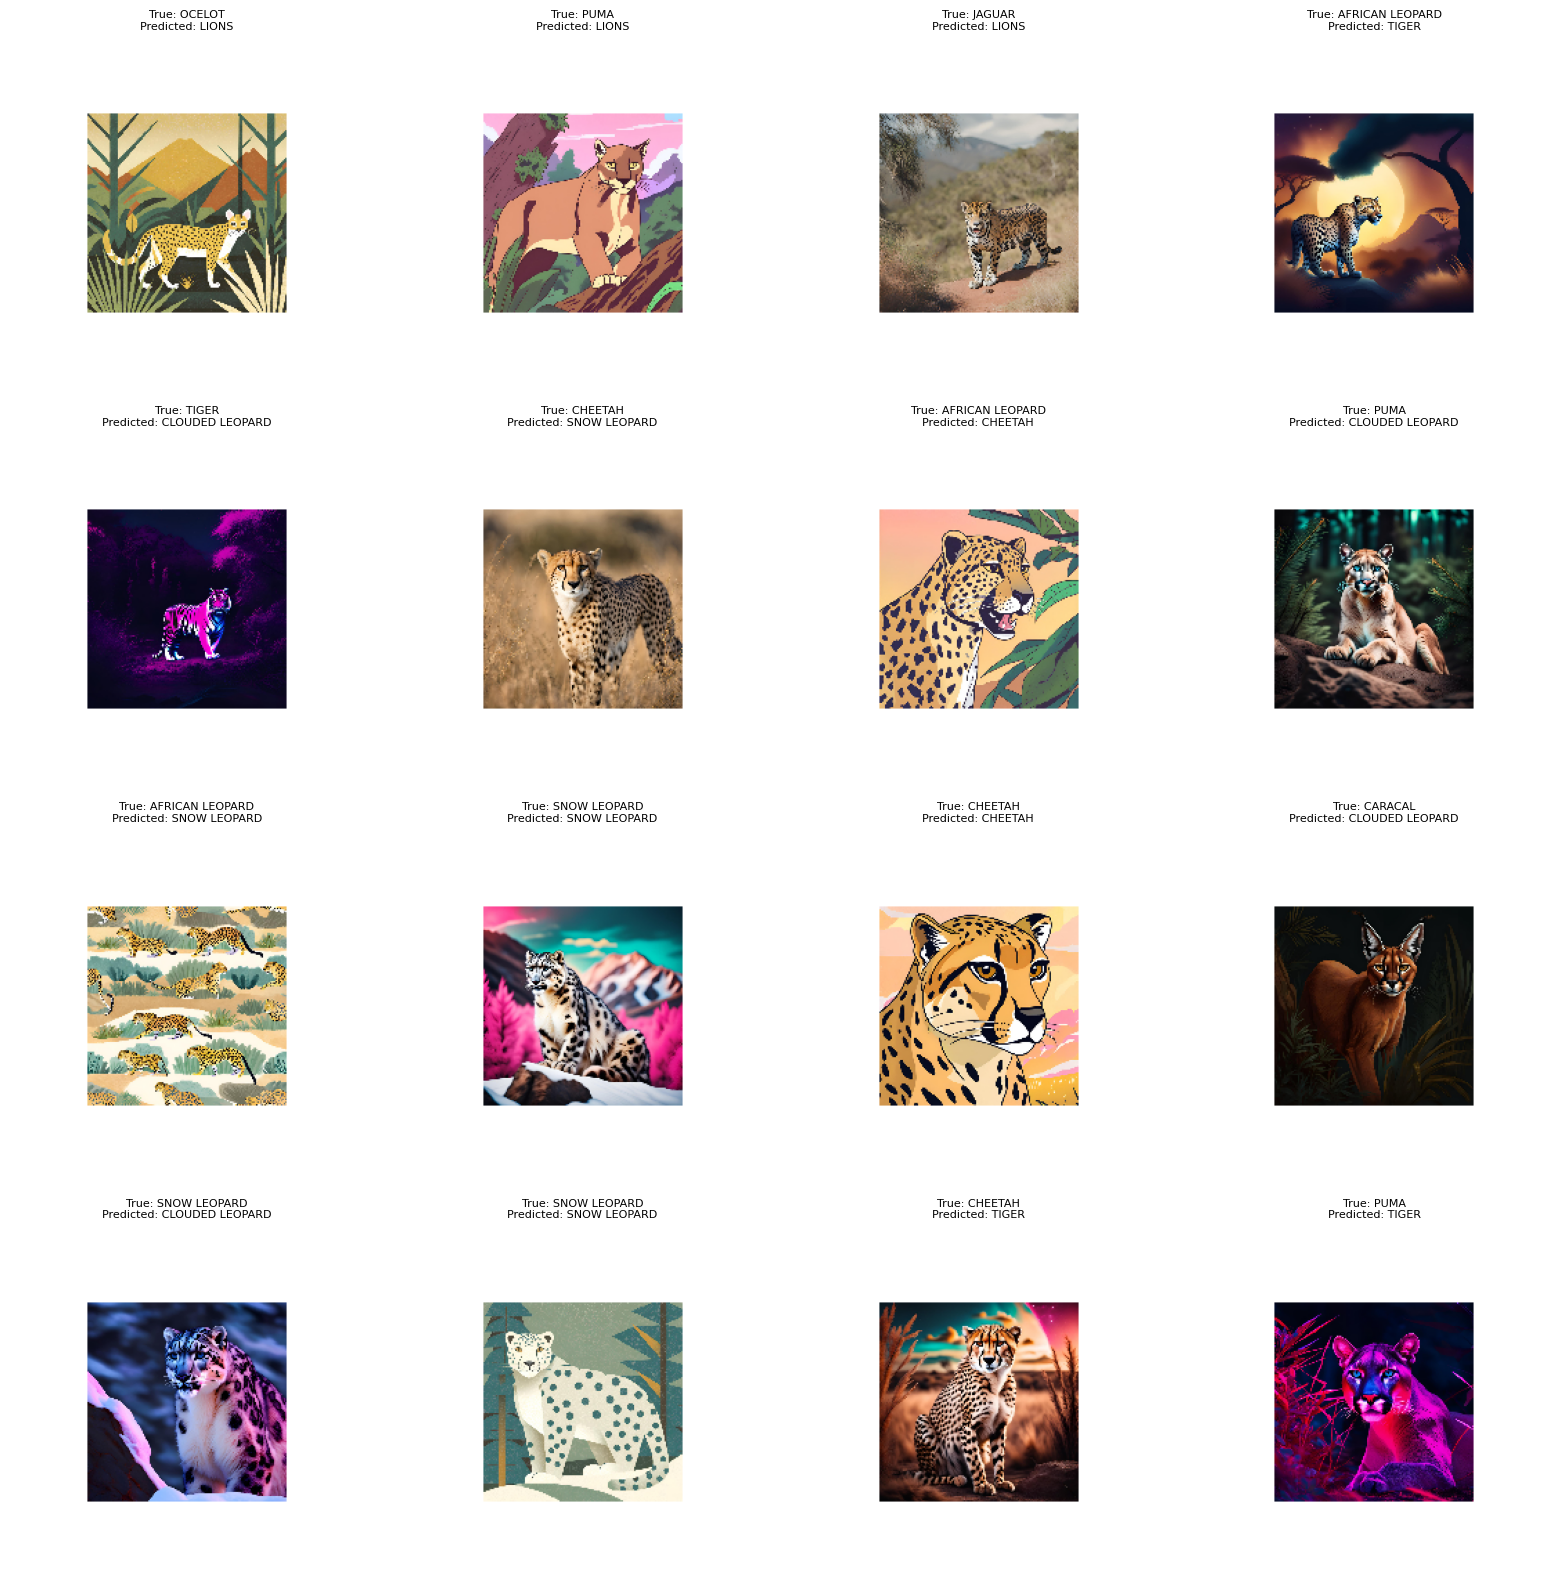

In [ ]:
# Collect true labels and model predictions
x_batch, y_batch = test_generator[0]
predictions = my_model.predict(x_batch)
true_labels = np.argmax(y_batch, axis=1)  # Convert one-hot encoded labels to class indices
predicted_labels = np.argmax(predictions, axis=1)

true_class_labels = [class_names[i] for i in true_labels]
predicted_class_labels = [class_names[i] for i in predicted_labels]

print(len(x_batch))
print(true_class_labels)
print(predicted_class_labels)

# Plot true labels and predicted labels
plt.figure(figsize=(16, 16))
for i in range(min(16, len(x_batch))):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_batch[i])
    plt.title(f'True: {true_class_labels[i]}\nPredicted: {predicted_class_labels[i]}', fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


fig.savefig("./results/dataDisplay.png")
plt.close()